In [4]:
from dotenv import load_dotenv
load_dotenv("C:\\Users\\praka\\Documents\\ML Hands-on\\.env")

True

# Chain


## Messages

In [5]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Chat Models


In [6]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama-3.3-70b-versatile")
result = llm.invoke(messages)
print(result)
type(result)

content="Orcas, also known as killer whales, are magnificent creatures. In the US, one of the best places to see Orcas is in the Pacific Northwest, particularly in the states of Washington and Alaska.\n\nSome of the top spots to see Orcas in the US include:\n\n1. **San Juan Islands, Washington**: Located off the coast of Washington state, the San Juan Islands are known for their resident Orca population. You can take a guided tour or kayak through the islands to spot these amazing animals.\n2. **Puget Sound, Washington**: Puget Sound is home to a large population of Orcas, and you can take a whale-watching tour from cities like Seattle or Tacoma to see them.\n3. **Juneau, Alaska**: Juneau is a great place to see Orcas in their natural habitat, and you can take a guided tour or visit the Auke Bay area to spot them.\n4. **Seward, Alaska**: Seward is a popular spot for whale-watching, and you can take a tour to see Orcas, as well as other marine wildlife like humpback whales and sea lions

langchain_core.messages.ai.AIMessage

## Tools


In [7]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [8]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tnh18pxfm', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 232, 'total_tokens': 251, 'completion_time': 0.048308826, 'prompt_time': 0.031745983, 'queue_time': 0.087809356, 'total_time': 0.080054809}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--eb12f1f3-2e54-4d17-bce9-88659e508d3a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'tnh18pxfm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 232, 'output_tokens': 19, 'total_tokens': 251})

In [19]:
llm_with_tools.invoke([HumanMessage(content=f"Hello", name="Lance")])

AIMessage(content="I'm here to help. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 225, 'total_tokens': 239, 'completion_time': 0.033623502, 'prompt_time': 0.025213756, 'queue_time': 0.194804015, 'total_time': 0.058837258}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--4b9a26a2-8d85-43bb-b3f1-53b5660f5634-0', usage_metadata={'input_tokens': 225, 'output_tokens': 14, 'total_tokens': 239})

In [9]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'tnh18pxfm',
  'type': 'tool_call'}]

## Using messages as state

In [10]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

In [11]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [12]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [15]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='d61f8bc2-cf93-4354-9157-c6533d78977d'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='37172b0b-8819-4236-83ee-2a5df635bdd0'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='01b5ea4b-5a19-473c-8db0-8ed090fec064')]

## Our graph

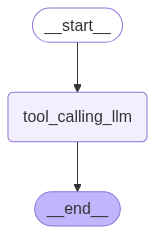

In [13]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
print(messages)
for m in messages['messages']:
    m.pretty_print()

{'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='36a9fc15-1d97-4d6e-b76b-9b0c33a7f2b0'), AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 226, 'total_tokens': 251, 'completion_time': 0.051415623, 'prompt_time': 0.024038776, 'queue_time': 0.194802301, 'total_time': 0.075454399}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--7adbc6f7-4a1c-4e8e-b964-dd1a7750aeaa-0', usage_metadata={'input_tokens': 226, 'output_tokens': 25, 'total_tokens': 251})]}
================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! It's nice to meet you. Is there something I can

In [20]:
messages = graph.invoke({"messages":[HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")]})
print(messages)
for m in messages['messages']:
    m.pretty_print()

{'messages': [HumanMessage(content='What is 2 multiplied by 3', additional_kwargs={}, response_metadata={}, name='Lance', id='391859a8-5e9d-4a2d-be1a-10288e11b2bb'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6pZHLT439rDVMFxohq9Ri6P8', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 62, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bp3h8yRcl8ANl4dvj6f2lhHUJK99x', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0926560b-134a-4fea-86df-3989e503d0e5-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_6pZHLT4